In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
# # kaggle dataset download setup
# # JSON path: /content/drive/MyDrive/ids_project/kaggle.json
# !pip install -q kaggle
# !mkdir ~/.kaggle

# !cp /content/drive/MyDrive/ids_project/kaggle.json ~/.kaggle/kaggle.json

In [3]:
# downloading kaggle dataset
# !kaggle datasets download mlg-ulb/creditcardfraud

In [4]:
# unzip
# !unzip creditcardfraud.zip

In [5]:
# read dataset
ccfd_df = pd.read_csv('/content/drive/MyDrive/ids_project/creditcard.csv')

In [6]:
ccfd_df.head(100)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,64.0,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
96,64.0,0.959602,0.370711,0.888613,2.343244,0.352491,1.365515,-0.277771,0.516053,-0.700929,...,-0.155547,-0.403239,0.356504,-0.696881,-0.198718,-0.220268,0.068546,0.020797,7.55,0
97,67.0,-0.653445,0.160225,1.592256,1.296832,0.997175,-0.343000,0.469937,-0.132470,-0.197794,...,0.038363,0.336449,-0.014883,0.102959,-0.265322,-0.348637,0.011238,-0.049478,19.85,0
98,67.0,-1.494668,0.837241,2.628211,3.145414,-0.609098,0.258495,-0.012189,0.102136,-0.286164,...,-0.140047,0.355044,0.332720,0.718193,-0.219366,0.118927,-0.317486,-0.340783,28.28,0


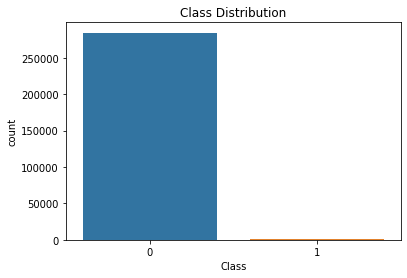

In [7]:
# The data is imbalanced, the graph shows the class distributions in the dataset 

sns.countplot(x='Class', data=ccfd_df)
plt.title('Class Distribution')
plt.show()

In [8]:
def print_metrics(y_test, y_pred):
  # plotting the confusion matrix
  plt.figure(figsize=(8, 8))
  plt.title('Confusion Matrix')

  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, xticklabels=["fraud", "non-fraud"], yticklabels=["fraud", "non-fraud"])

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # metrcis
  print("")
  print("Accuracy  :", accuracy_score(y_test, y_pred))
  print("Recall    :", recall_score(y_test, y_pred))
  print("Precision :", precision_score(y_test, y_pred))
  print("F1-score  :", f1_score(y_test, y_pred))
  print("ROC AUC   :", roc_auc_score(y_test, y_pred))
  print("")

In [9]:
#
# Builds a decision tree by under sampling the data.
# Undersample the majority class by clustering and use the cluster centroids as the new data
#
# input : input dataframe
# target_col : target column name in the input dataframe
#

def decision_with_undersampling(input, target_col):
  
  print("Decision Tree with undersampling input:\n")
  # initialize the ClusterCentroid sampler & undersample the input
  cc_under_sampler = ClusterCentroids(sampling_strategy='not minority', random_state=9)
  x_us, y_us = cc_under_sampler.fit_resample(X=input.loc[:,input.columns != target_col], y=input[target_col])

  # Train-Test split
  X_train, X_test, y_train, y_test = train_test_split(x_us, y_us, test_size=0.3)

  # initalize the Decision Tree Classifier
  dt_classifier = DecisionTreeClassifier()

  # cross validation - RepeatedKFoald
  rkf = RepeatedKFold()
  cv_scores = cross_validate(dt_classifier, X_train, y_train, cv=rkf.split(X_train, y_train), scoring=['accuracy', 'roc_auc'])

  # fit
  model = dt_classifier.fit(X_train, y_train)

  # predict 
  y_pred = model.predict(X_test)

  # print mentrcis
  print_metrics(y_test, y_pred)

In [10]:
#
# Builds a decision tree with oversampling the minority class
# Oversampling is done using SMOTE
#

def decision_with_oversampling(input, target_col):
  
  # initialize SMOTE and oversample the input data
  smote_over_sampler = SMOTE()
  x_os, y_os = smote_over_sampler.fit_resample(X=input.loc[:,input.columns != target_col], y=input[target_col])

  # train-test split
  X_train, X_test, y_train, y_test = train_test_split(x_os, y_os, test_size=0.3)

  # initalize the Decision Tree Classifier
  dt_classifier = DecisionTreeClassifier()  

  # cross validation
  cv_scores = cross_val_score(dt_classifier, X_train, y_train)

  # fit
  model = dt_classifier.fit(X_train, y_train)

  # predict 
  y_pred = model.predict(X_test)
  print("Decsion Tree with oversampling:\n")
  
  # print mentrcis
  print_metrics(y_test, y_pred)

Decision Tree with undersampling input:



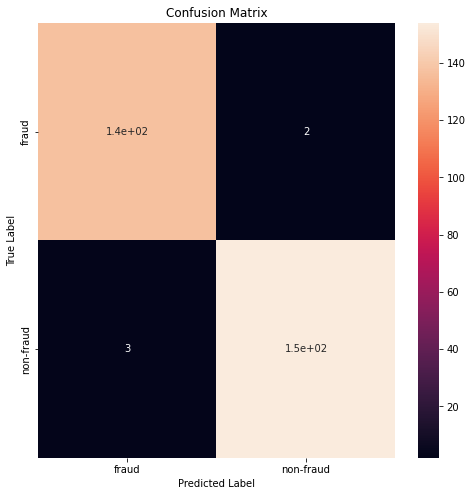


Accuracy  : 0.9831081081081081
Recall    : 0.9808917197452229
Precision : 0.9871794871794872
F1-score  : 0.9840255591054313
ROC AUC   : 0.9832516152682949



In [11]:
decision_with_undersampling(ccfd_df, 'Class')

Decsion Tree with oversampling:



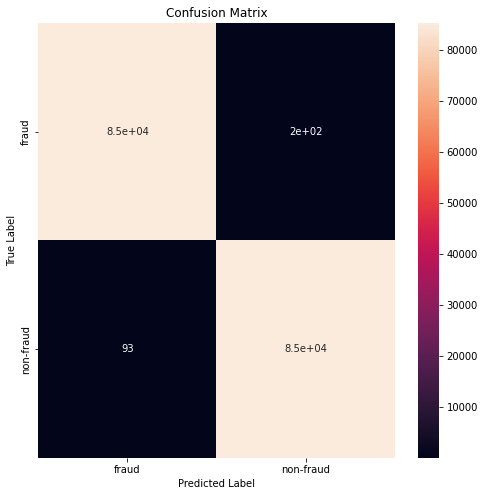


Accuracy  : 0.9983117317060303
Recall    : 0.9989100498095517
Precision : 0.99771734931579
F1-score  : 0.9983133433283358
ROC AUC   : 0.9983115176801558



In [12]:
decision_with_oversampling(ccfd_df, 'Class')